<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer_(III).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

Check GPU

In [1]:
!nvidia-smi

Sat May 18 09:02:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Check our directory as `/content`

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create datasets directory

In [4]:
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


Change to /datasets and download and unzip dataset

In [5]:
# Change to new datasets folder
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp0.zip'):
  !wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets


Obtain dirs for  train, test y val sets. Calculate median and standard desviation in order to normalize all images

In [6]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# 1. Calculate the mean and standard deviation on the training set.
# train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir  = "/content/datasets/exp0/test/"
test_dir   = "/content/datasets/exp0/val/"

# transform to calculate mean and standard desviation
transform = transforms.Compose([
    transforms.ToTensor()  # transform images to tensor
])

# Load the ImageFolder dataset and apply the transformation
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# it's better to use a loader to retrieve images (tensors)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to store the sum of pixel values and
# standard deviation.
# These variables are set to floating-point zeros to ensure
# accurate calculations.
mean_sum = 0.0
std_sum = 0.0
total_samples = 0

# Iterates over the data loader (loader),
# calculates the mean and standard deviation across all channels
# for each batch(0) and spatial dimensions (height(2) and width(3))
for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Total train samples:", total_samples)
print("Mean:", mean)
print("Std:", std)

Total train samples: 2700
Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])


Normalize datasets

In [7]:
# 2. Normalize the training set using these statistics.
train_set = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# 3. Normalize the test and validation set using the same statistics
# calculated on the training set.
val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_set.classes
print('Classes: ', classes)

Length of Train Data :2700
Length of Validation Data : 600
Length of Test Data : 300
Classes:  ['class_0', 'class_1']


Define train process

In [8]:
def train(dataloader, model, criterion, optimizer):
  running_loss, corrects, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  print(f"Training:")
  model.train() #training mode on
  loop = tqdm(train_dataloader) # Initialize a progress bar
  for batch, (X, y) in enumerate(loop):
    # take data (X) and label (y) from a batch
    X, y = X.to(device), y.to(device) # Move the data and labels
                                      # to the device (CPU or GPU)

    # forward pass
    preds = model(X) # Compute predictions
    loss = criterion(preds, y) # Compute the loss between predictions and labels

    # backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()         # compute gradients to backwards
    optimizer.step()        # Does the "update weights" of model

    # Calculate Output Metrics training_loss, training_accuracy

    # 1. loss.item() contains the loss of entire mini-batch converted to scalar
    running_loss += loss.item() # Accumulate the loss for this batch

    # 2. current image (last image in the batch) for progressive bar
    current += len(X) # Update the current number of processed images

    # 3. From the predictions, I select the index (class) of the one with
    # the highest value and compare it with the label (class). The boolean value
    # is converted into a float (true becomes 1, false becomes 0), and all are
    # summed up. Finally, 'item' converts them into a scalar value.
    # This way, 'corrects' reflects the number of correct predictions (accuracy)
    corrects += (preds.argmax(1) == y).type(torch.float).sum().item()

    # 4. running loss is the sum of our loss. Training loss is a running average
    # through batches
    training_loss = running_loss/(batch+1)

    # 5. Training accuracy = number of corrects predictions/number of processed images
    training_accuracy = corrects/current

    # Update the progress bar with current epoch, batch, and metrics
    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')
    loop.set_postfix(Training_Loss=training_loss, Accuracy=f'{100*corrects/current:>0.1f}%')

  return training_loss, training_accuracy

Define validation process

In [9]:
def val(dataloader, model, criterion):
  size = len(dataloader.dataset) # number images from dataset to evaluate
  num_batches = len(dataloader)  # number of batches

  # Evaluation (test)) Mode
  model.eval()

  val_loss, corrects = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # prediction for a dataset not used in training
      # compute prediction error and number of corrects
      # through batches
      preds = model(X)
      val_loss += criterion(preds, y).item()
      corrects += (preds.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  corrects /= size
  print(f"Val: \n Accuracy: {(100*corrects):>0.1f}%, val_Loss: {val_loss:>8f} \n")

  return val_loss, corrects

Load previously weights saved model. We  need the architecture of saved model in order to weights matching with the layers of the model.

In [10]:
import torch.nn as nn

# Large Model
class myCNN(nn.Module):
    def __init__(self): # defines the constructor method __init__()
                        # for the myCNN class. This method is called
                        # when an instance of the class is created.
        super().__init__() # calls the constructor of the parent class
                           # (nn.Module) using Python's super() function.
                           # It initializes the parent class, allowing the
                           # myCNN class to inherit functionality from nn.Module.

        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )
    # The forward method takes a single argument xb,
    # which represents the input data to the neural network.
    # Inside the forward method, the input xb is passed through the
    # neural network layers defined in self.network. The result of this
    # computation is then returned as the output of the forward method.
    def forward(self, xb):
        return self.network(xb)

Interactive with ypour local folder to load the weights

In [11]:
from google.colab import files

model = files.upload()

Saving myCNN.pth to myCNN.pth


Create a instance (in cuda if it is possible) of our model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Create a instance from your model
model = myCNN().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)


Using cuda device
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear


# Early Stopping

Early stopping is a technique used in machine learning model training to halt training before the model begins to overfit the training data. This is done by monitoring a metric of interest on the validation set and stopping training when the metric ceases to improve for a certain number of consecutive epochs.

You can use the Python standard library os to create a directory named `"train"` in the current directory and then save the trained models (pth) in that directory. Here's an example of how to do it:


To create directories named `train1`, `train2`, etc., each time you execute a training loop, you can modify the code to check the number of existing training directories and then create the next directory in sequence. Here's an example of how you could do this:

In [13]:
import os
import torchvision.models as models

def create_train_dir():
  """
  Creates a directory named train within the current directory.
  """
  # Current directory
  current_dir = os.getcwd()
  print(current_dir)

  # Base path to the "train" directory
  base_train_dir = os.path.join(current_dir, 'train')

  # Determine the next training directory name
  train_dirs = [d for d in os.listdir(current_dir) if d.startswith('train') and d[5:].isdigit()]
  train_dirs.sort(key=lambda x: int(x[5:]) if x[5:].isdigit() else -1)
  next_train_num = 1 if not train_dirs else int(train_dirs[-1][5:]) + 1
  train_dir = os.path.join(current_dir, f'train{next_train_num}')

  # Create the next training directory
  os.makedirs(train_dir, exist_ok=True)
  print(f"Training directory: {train_dir}")
  return train_dir

In [14]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 32
# epochs define the number of iterations
epochs = 20
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


In [15]:
# Create dataloaders object for training/val loop.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

In [16]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
# Define your optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## [Checkpoints and Early Stopping](https://machinelearningmastery.com/managing-a-pytorch-training-process-with-checkpoints-and-early-stopping/)

Application checkpointing is a **fault tolerance technique**. In this approach, a *snapshot of the state of the system is taken in case of system failure*. If there is a problem, you can resume from the snapshot. The checkpoint may be used directly or as the starting point for a new run, picking up where it left off. When training deep learning models, the checkpoint captures the weights of the model. These weights can be used to make predictions as-is or as the basis for ongoing training.

PyTorch does not provide any function for checkpointing but it has functions for retrieving and restoring weights of a model. So you can implement checkpointing logic with them. Let’s make a checkpoint and a resume function, which simply save weights from a model and load them back:

In [17]:
import torch

def checkpoint(model, filename):
  model_path = os.path.join(train_dir, filename)
  torch.save(model.state_dict(), model_path)

def resume(model, filename):
  model.load_state_dict(torch.load(filename))


If you want to add checkpoints to the training loop, you can do it at the end of the outer for-loop, where the model validation with the test set is done.

You will see a number of files created in your working directory. This code is going to checkpoint the model fro each epoch. Each of these file is a ZIP file with the pickled model weight. Nothing forbid you to checkpoint inside the inner for-loop but due to the overhead it incurs, it is not a good idea to checkpoint too frequent.

In [18]:
from tqdm import tqdm # progress bar
import csv

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

#create directory for training metrics store
train_dir = create_train_dir()

for epoch in range(epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_val,acc_val= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)
  checkpoint(model, os.path.join(train_dir, f"epoch-{epoch}.pth"))

# save metrics in a .CSV file.
with open(os.path.join(train_dir,'metrics_myCNN.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
    for epoch, (train_loss, train_accuracy, val_loss, val_accuracy) in enumerate(zip(loss_train_history, accuracy_train_history, loss_val_history, accuracy_val_history)):
        writer.writerow([epoch+1, train_loss, train_accuracy, val_loss, val_accuracy])


print("Done!. Finished Training")

/content/datasets
Training directory: /content/datasets/train1
Training:


  0%|          | 0/85 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[1/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  7.85it/s, Accuracy=50.0%, Training_Loss=0.693]


Val: 
 Accuracy: 50.0%, val_Loss: 0.693442 

Training:


[2/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.34it/s, Accuracy=50.0%, Training_Loss=0.693]


Val: 
 Accuracy: 50.0%, val_Loss: 0.693154 

Training:


[3/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.13it/s, Accuracy=50.0%, Training_Loss=0.693]


Val: 
 Accuracy: 50.0%, val_Loss: 0.693020 

Training:


[4/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.01it/s, Accuracy=50.0%, Training_Loss=0.693]


Val: 
 Accuracy: 50.0%, val_Loss: 0.692902 

Training:


[5/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.91it/s, Accuracy=59.0%, Training_Loss=0.693]


Val: 
 Accuracy: 50.2%, val_Loss: 0.692762 

Training:


[6/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.13it/s, Accuracy=53.5%, Training_Loss=0.693]


Val: 
 Accuracy: 50.5%, val_Loss: 0.692655 

Training:


[7/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.42it/s, Accuracy=50.0%, Training_Loss=0.693]


Val: 
 Accuracy: 50.3%, val_Loss: 0.692518 

Training:


[8/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.04it/s, Accuracy=53.6%, Training_Loss=0.692]


Val: 
 Accuracy: 49.7%, val_Loss: 0.692362 

Training:


[9/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.95it/s, Accuracy=54.4%, Training_Loss=0.692]


Val: 
 Accuracy: 67.5%, val_Loss: 0.692077 

Training:


[10/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.71it/s, Accuracy=58.4%, Training_Loss=0.692]


Val: 
 Accuracy: 50.5%, val_Loss: 0.691819 

Training:


[11/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.76it/s, Accuracy=57.4%, Training_Loss=0.692]


Val: 
 Accuracy: 70.8%, val_Loss: 0.691215 

Training:


[12/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.92it/s, Accuracy=65.4%, Training_Loss=0.691]


Val: 
 Accuracy: 71.2%, val_Loss: 0.690416 

Training:


[13/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.16it/s, Accuracy=63.0%, Training_Loss=0.69]


Val: 
 Accuracy: 70.0%, val_Loss: 0.689126 

Training:


[14/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.44it/s, Accuracy=69.5%, Training_Loss=0.688]


Val: 
 Accuracy: 69.5%, val_Loss: 0.686617 

Training:


[15/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.04it/s, Accuracy=67.4%, Training_Loss=0.685]


Val: 
 Accuracy: 70.0%, val_Loss: 0.681289 

Training:


[16/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.16it/s, Accuracy=68.3%, Training_Loss=0.677]


Val: 
 Accuracy: 70.3%, val_Loss: 0.669408 

Training:


[17/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.16it/s, Accuracy=68.2%, Training_Loss=0.655]


Val: 
 Accuracy: 68.5%, val_Loss: 0.630806 

Training:


[18/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.89it/s, Accuracy=68.1%, Training_Loss=0.595]


Val: 
 Accuracy: 70.0%, val_Loss: 0.570416 

Training:


[19/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.88it/s, Accuracy=69.9%, Training_Loss=0.559]


Val: 
 Accuracy: 71.2%, val_Loss: 0.552556 

Training:


[20/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.95it/s, Accuracy=71.1%, Training_Loss=0.546]


Val: 
 Accuracy: 72.0%, val_Loss: 0.537914 

Done!. Finished Training


The question is of all model which is the best one? It will be studied forward.

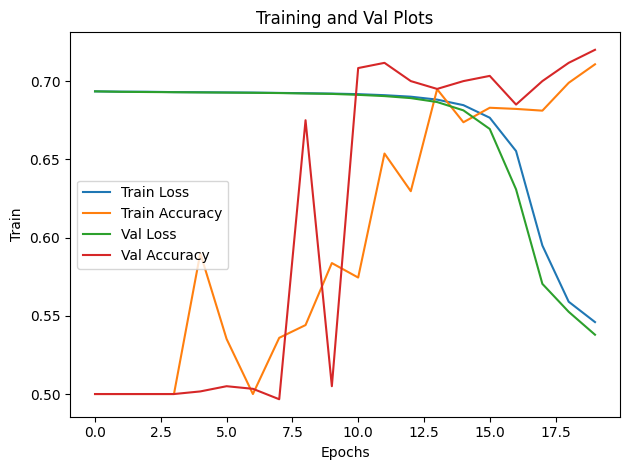

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title('Training and Val Plots')
ax.plot(range(epochs), loss_train_history, label="Train Loss")
ax.plot(range(epochs), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epochs), loss_val_history, label="Val Loss")
ax.plot(range(epochs), accuracy_val_history, label="Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

You can use a fault tolerance technique where training resumes from a particular epoch. That is, if the training loop was interrupted in the middle of epoch 3 so the last checkpoint is from epoch 2, setting start_epoch = 3 above will do.

This action cannot be simulated in jupyter notebook because we cannot  halt the cell, anyway the code could be this.
```python
epochs = 10

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

#create directory for training metrics store
train_dir = create_train_dir()

start_epoch = 0
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"epoch-{resume_epoch}.pth")

for epoch in range(start_epoch, epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_val,acc_val= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_test_history.append(acc_val)
  checkpoint(model, os.path.join(train_dir, f"epoch-{epoch}.pth"))

# save metrics in a .CSV file.
with open(os.path.join(train_dir,'metrics_myCNN.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
    for epoch, (train_loss, train_accuracy, val_loss, val_accuracy) in enumerate(zip(loss_train_history, accuracy_train_history, loss_test_history, accuracy_test_history)):
        writer.writerow([epoch+1, train_loss, train_accuracy, val_loss, val_accuracy])

print("Done!. Finished Training")
```



Sometimes, there are states outside of the model and you may want to checkpoint it as well. One particular example is the optimizer, which in cases like SDG or Adam, there are dynamically adjusted momentum. If you restarted your training loop, you may want to restore the momentum at the optimizer as well. It is not difficult to do. The idea is to make your `checkpoint()` function more complicated thanks to `torch.save()` and `torch.load()` function are backed by `pickle`, so you can use it with a list or dict container.

In [20]:
def checkpoint(model, filename):
    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename)['model'])
    optimizer.load_state_dict(torch.load(filename)['optimizer'])


In [21]:
loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

#create directory for training metrics store
train_dir = create_train_dir()

start_epoch = 0
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, os.path.join(train_dir,f"epoch-{resume_epoch}.pth"))

for epoch in range(start_epoch, epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_val,acc_val= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)
  checkpoint(model, os.path.join(train_dir,f"epoch-{epoch}.pth"))
print("Done!. Finished Training")

/content/datasets
Training directory: /content/datasets/train2
Training:


[1/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.09it/s, Accuracy=71.2%, Training_Loss=0.539]


Val: 
 Accuracy: 72.5%, val_Loss: 0.528124 

Training:


[2/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.52it/s, Accuracy=71.8%, Training_Loss=0.531]


Val: 
 Accuracy: 72.3%, val_Loss: 0.526711 

Training:


[3/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.14it/s, Accuracy=72.4%, Training_Loss=0.523]


Val: 
 Accuracy: 73.2%, val_Loss: 0.520893 

Training:


[4/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  7.79it/s, Accuracy=72.6%, Training_Loss=0.518]


Val: 
 Accuracy: 73.7%, val_Loss: 0.503992 

Training:


[5/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.11it/s, Accuracy=72.7%, Training_Loss=0.511]


Val: 
 Accuracy: 74.2%, val_Loss: 0.496985 

Training:


[6/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.03it/s, Accuracy=73.5%, Training_Loss=0.5]


Val: 
 Accuracy: 74.5%, val_Loss: 0.493744 

Training:


[7/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.67it/s, Accuracy=73.6%, Training_Loss=0.502]


Val: 
 Accuracy: 74.3%, val_Loss: 0.492005 

Training:


[8/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.16it/s, Accuracy=73.9%, Training_Loss=0.495]


Val: 
 Accuracy: 74.0%, val_Loss: 0.491484 

Training:


[9/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.16it/s, Accuracy=73.9%, Training_Loss=0.492]


Val: 
 Accuracy: 74.7%, val_Loss: 0.485826 

Training:


[10/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.11it/s, Accuracy=74.4%, Training_Loss=0.49]


Val: 
 Accuracy: 74.7%, val_Loss: 0.488920 

Training:


[11/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.17it/s, Accuracy=73.9%, Training_Loss=0.497]


Val: 
 Accuracy: 74.8%, val_Loss: 0.482622 

Training:


[12/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.58it/s, Accuracy=75.1%, Training_Loss=0.48]


Val: 
 Accuracy: 75.5%, val_Loss: 0.479201 

Training:


[13/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.48it/s, Accuracy=75.0%, Training_Loss=0.478]


Val: 
 Accuracy: 75.3%, val_Loss: 0.477505 

Training:


[14/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.09it/s, Accuracy=74.3%, Training_Loss=0.487]


Val: 
 Accuracy: 75.0%, val_Loss: 0.474984 

Training:


[15/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.01it/s, Accuracy=75.2%, Training_Loss=0.472]


Val: 
 Accuracy: 75.5%, val_Loss: 0.474591 

Training:


[16/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.82it/s, Accuracy=75.4%, Training_Loss=0.47]


Val: 
 Accuracy: 76.2%, val_Loss: 0.469314 

Training:


[17/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.30it/s, Accuracy=75.1%, Training_Loss=0.47]


Val: 
 Accuracy: 75.8%, val_Loss: 0.483481 

Training:


[18/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.22it/s, Accuracy=75.6%, Training_Loss=0.475]


Val: 
 Accuracy: 76.2%, val_Loss: 0.473175 

Training:


[19/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.04it/s, Accuracy=75.0%, Training_Loss=0.468]


Val: 
 Accuracy: 75.5%, val_Loss: 0.471755 

Training:


[20/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.94it/s, Accuracy=75.0%, Training_Loss=0.47]


Val: 
 Accuracy: 76.3%, val_Loss: 0.467007 

Done!. Finished Training


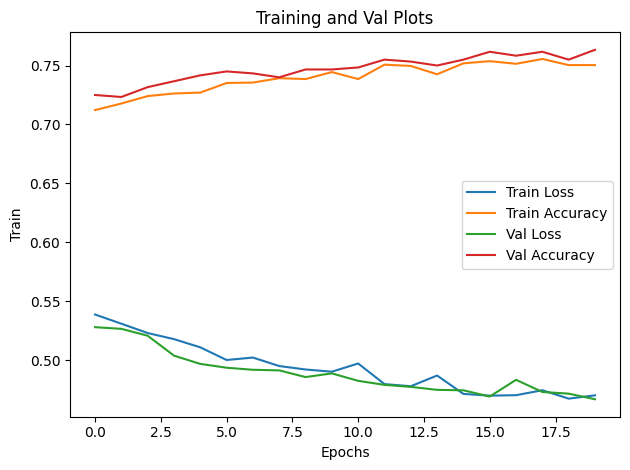

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title('Training and Val Plots')
ax.plot(range(epochs), loss_train_history, label="Train Loss")
ax.plot(range(epochs), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epochs), loss_val_history, label="Val Loss")
ax.plot(range(epochs), accuracy_val_history, label="Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

Checkpointing is not only for fault tolerance. You can also use it to keep your best model. How to define what is the best is `subjective` but considering the score from the test set is a sensible method. Let’s say to keep only the best model ever found.

The variable `best_accuracy` is to keep track on the highest validation accuracy (`val_acc`) obtained so far, which is in a percentage range of 0 to 100. Whenever a higher accuracy is observed, the model is checkpointed to the file `best_model.pth`. The best model is restored after the entire training loop, via the `resume()` function which was created before.

Afterward, you can make predictions with the model on unseen data. Beware that, if you’re using a different metric for checkpointing, e.g., the cross entropy loss, the better model should come with a lower cross entropy. Thus you should keep track on the lowest cross entropy obtained.


The training loop can be modified as follows:

In [23]:
best_accuracy = -1


loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

#create directory for training metrics store
train_dir = create_train_dir()

start_epoch = 0
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, os.path.join(train_dir,f"epoch-{resume_epoch}.pth"))

for epoch in range(start_epoch, epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_val,acc_val= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)
  if acc_val > best_accuracy:
    best_accuracy = acc_val
    checkpoint(model, os.path.join(train_dir,f"epoch-{epoch}.pth"))
    print(f'best model in epoch:{epoch+1}')
print("Done!. Finished Training")

/content/datasets
Training directory: /content/datasets/train3
Training:


[1/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.60it/s, Accuracy=76.3%, Training_Loss=0.462]


Val: 
 Accuracy: 75.0%, val_Loss: 0.470082 

best model in epoch:1
Training:


[2/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.23it/s, Accuracy=76.6%, Training_Loss=0.459]


Val: 
 Accuracy: 75.5%, val_Loss: 0.464002 

best model in epoch:2
Training:


[3/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.07it/s, Accuracy=75.5%, Training_Loss=0.467]


Val: 
 Accuracy: 74.3%, val_Loss: 0.509742 

Training:


[4/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s, Accuracy=76.7%, Training_Loss=0.457]


Val: 
 Accuracy: 77.2%, val_Loss: 0.456412 

best model in epoch:4
Training:


[5/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.99it/s, Accuracy=76.0%, Training_Loss=0.454]


Val: 
 Accuracy: 76.2%, val_Loss: 0.473463 

Training:


[6/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.39it/s, Accuracy=76.0%, Training_Loss=0.458]


Val: 
 Accuracy: 78.2%, val_Loss: 0.457767 

best model in epoch:6
Training:


[7/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.23it/s, Accuracy=76.7%, Training_Loss=0.449]


Val: 
 Accuracy: 75.8%, val_Loss: 0.482760 

Training:


[8/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.66it/s, Accuracy=75.4%, Training_Loss=0.464]


Val: 
 Accuracy: 77.0%, val_Loss: 0.453802 

Training:


[9/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.50it/s, Accuracy=76.2%, Training_Loss=0.458]


Val: 
 Accuracy: 77.7%, val_Loss: 0.457607 

Training:


[10/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.07it/s, Accuracy=77.2%, Training_Loss=0.446]


Val: 
 Accuracy: 76.3%, val_Loss: 0.468921 

Training:


[11/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.90it/s, Accuracy=76.6%, Training_Loss=0.45]


Val: 
 Accuracy: 77.5%, val_Loss: 0.470216 

Training:


[12/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.24it/s, Accuracy=76.6%, Training_Loss=0.45]


Val: 
 Accuracy: 75.8%, val_Loss: 0.469640 

Training:


[13/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.55it/s, Accuracy=77.0%, Training_Loss=0.438]


Val: 
 Accuracy: 76.7%, val_Loss: 0.459171 

Training:


[14/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.16it/s, Accuracy=77.5%, Training_Loss=0.447]


Val: 
 Accuracy: 76.0%, val_Loss: 0.461374 

Training:


[15/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.45it/s, Accuracy=77.8%, Training_Loss=0.441]


Val: 
 Accuracy: 76.8%, val_Loss: 0.456294 

Training:


[16/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s, Accuracy=77.1%, Training_Loss=0.443]


Val: 
 Accuracy: 77.7%, val_Loss: 0.454344 

Training:


[17/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.01it/s, Accuracy=78.1%, Training_Loss=0.43]


Val: 
 Accuracy: 76.7%, val_Loss: 0.470138 

Training:


[18/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.10it/s, Accuracy=77.6%, Training_Loss=0.435]


Val: 
 Accuracy: 76.5%, val_Loss: 0.454291 

Training:


[19/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.71it/s, Accuracy=78.1%, Training_Loss=0.438]


Val: 
 Accuracy: 77.0%, val_Loss: 0.449207 

Training:


[20/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.04it/s, Accuracy=78.3%, Training_Loss=0.443]


Val: 
 Accuracy: 76.3%, val_Loss: 0.456972 

Done!. Finished Training


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title('Training and Val Plots')
ax.plot(range(epoch+1), loss_train_history, label="Train Loss")
ax.plot(range(epoch+1), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epoch+1), loss_val_history, label="Val Loss")
ax.plot(range(epoch+1), accuracy_val_history, label="Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

You can also checkpoint the model per epoch unconditionally together with the best model checkpointing, as you are free to create multiple checkpoint files. Since the code above is the find the best model and make a copy of it, you may usually see a further optimization to the training loop by stopping it early if the hope to see model improvement is slim. This is the early stopping technique that can save time in training.

The code above validates the model with test set at the end of each epoch and keeps the best model found into a checkpoint file. The simplest strategy for early stopping is to set up a threshold of
 epochs. If you didn’t see the model improved over the last
 epochs, you terminate the training loop in the middle. This can be implemented as follows:

In [24]:
early_stop_thresh = 5
best_accuracy = -1
best_epoch = -1


loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

#create directory for training metrics store
train_dir = create_train_dir()


for epoch in range(epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_test= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)
  if acc_val > best_accuracy:
    best_accuracy = acc_val
    best_epoch = epoch+1
    checkpoint(model, os.path.join(train_dir,f"best_model.pth"))
    print(f'best model in epoch={epoch+1} with Accuracy={(100*acc_val):>0.1f}%')
  elif epoch - best_epoch >= early_stop_thresh:
    print(f"Early stopped training at epoch {epoch+1} due to {early_stop_thresh} epochs whitout enhacement")
    break  # terminate the training loop
print("Done!. Finished Training")

/content/datasets
Training directory: /content/datasets/train4
Training:


[1/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.18it/s, Accuracy=77.5%, Training_Loss=0.437]


Val: 
 Accuracy: 77.7%, val_Loss: 0.447106 

best model in epoch=1 with Accuracy=76.3%
Training:


[2/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.74it/s, Accuracy=78.0%, Training_Loss=0.434]


Val: 
 Accuracy: 78.5%, val_Loss: 0.444142 

Training:


[3/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.45it/s, Accuracy=77.8%, Training_Loss=0.431]


Val: 
 Accuracy: 78.2%, val_Loss: 0.454172 

Training:


[4/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.13it/s, Accuracy=77.7%, Training_Loss=0.433]


Val: 
 Accuracy: 78.7%, val_Loss: 0.455299 

Training:


[5/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.18it/s, Accuracy=78.7%, Training_Loss=0.427]


Val: 
 Accuracy: 78.3%, val_Loss: 0.440646 

Training:


[6/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.92it/s, Accuracy=79.2%, Training_Loss=0.422]


Val: 
 Accuracy: 77.3%, val_Loss: 0.466690 

Training:


[7/20 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.87it/s, Accuracy=79.0%, Training_Loss=0.426]


Val: 
 Accuracy: 77.2%, val_Loss: 0.467979 

Early stopped training at epoch 7 due to 5 epochs whitout enhacement
Done!. Finished Training


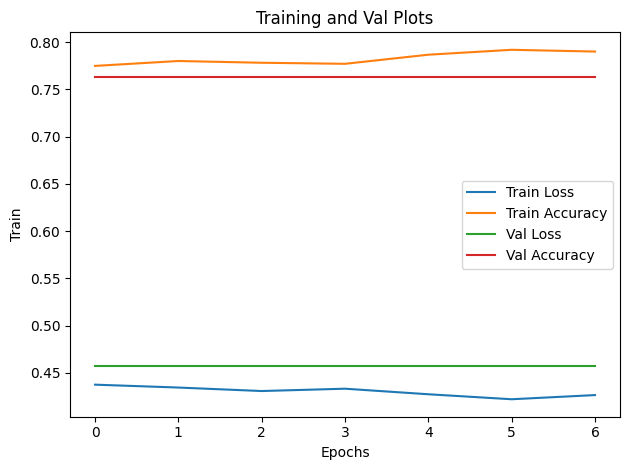

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title('Training and Val Plots')
ax.plot(range(epoch+1), loss_train_history, label="Train Loss")
ax.plot(range(epoch+1), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epoch+1), loss_val_history, label="Val Loss")
ax.plot(range(epoch+1), accuracy_val_history, label="Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

In [ ]:
from google.colab import files

model = files.upload()